In [1]:
#import pymongo
#from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
from splinter import Browser
from bs4 import BeautifulSoup
from webdriver_manager.chrome import ChromeDriverManager
from pprint import pprint
#from config import user, pw

In [2]:
executable_path = {'executable_path': ChromeDriverManager().install()}
browser = Browser('chrome', **executable_path, headless=False)
url = 'https://data-class-mars-challenge.s3.amazonaws.com/Mars/index.html'
browser.visit(url)

In [3]:
# HTML object
html = browser.html

# Parse HTML with Beautiful Soup
soup = BeautifulSoup(html, 'html.parser')

# Retrieve all elements that relevant information
ths = soup.find_all('th')
trs = soup.find_all('tr', class_='data-row')

# Lists to hold scraped data
table_headers = []
ids = []
terrestrial_dates = []
sols = []
lss = []
months = []
min_temps = []
pressures = []

# List of table headers
for th in ths:
    table_headers.append(th.text)

# Iterate through each row
for tr in trs:
    
    # ID
    td = tr.find('td')
    ids.append(int(td.text))
    
    # terrestrial dates
    terrestrial_dates.append(td.find_next_sibling("td").text)
    td = td.find_next_sibling("td")
    
    # sol
    sols.append(int(td.find_next_sibling("td").text))
    td = td.find_next_sibling("td")
    
    # ls
    lss.append(int(td.find_next_sibling("td").text))
    td = td.find_next_sibling("td")
    
    # month
    months.append(int(td.find_next_sibling("td").text))
    td = td.find_next_sibling("td")
    
    # min_temp
    min_temps.append(float(td.find_next_sibling("td").text))
    td = td.find_next_sibling("td")
    
    # pressure
    pressures.append(float(td.find_next_sibling("td").text))

In [5]:
# Create a new dataframe with the data that was scraped
mars_df = pd.DataFrame(columns = table_headers)
mars_df["id"] = ids
mars_df["terrestrial_date"] = terrestrial_dates
mars_df["sol"] = sols
mars_df["ls"] = lss
mars_df["month"] = months
mars_df["min_temp"] = min_temps
mars_df["pressure"] = pressures

In [6]:
# Convert terrestrial_date column from string to datetime
mars_df["terrestrial_date"] = mars_df["terrestrial_date"].astype("datetime64[ns]")

In [7]:
mars_df.head()

,id,terrestrial_date,sol,ls,month,min_temp,pressure
0,2,2012-08-16,10,155,6,-75.0,739.0
1,13,2012-08-17,11,156,6,-76.0,740.0
2,24,2012-08-18,12,156,6,-76.0,741.0
3,35,2012-08-19,13,157,6,-74.0,732.0
4,46,2012-08-20,14,157,6,-74.0,740.0


# Analysis

## How many months exist on Mars?

In [8]:
print(mars_df["month"].unique())
print("There are 12 months in a Martian year")

[ 6  7  8  9 10 11 12  1  2  3  4  5]
There are 12 months in a Martian year


## How many Martian (and not Earth) days worth of data exist in the scraped dataset?

I can calculate this by taking the earliest sol in the dataset and subtracting that from the latest sol in the dataset.

In [9]:
min_sol = mars_df["sol"].min()
max_sol = mars_df["sol"].max()
sol_elapsed = max_sol - min_sol

In [10]:
print(f"There are {sol_elapsed} Martian days worth of data that exist in the scraped dataset.")

There are 1967 Martian days worth of data that exist in the scraped dataset.


## What are the coldest and the warmest months on Mars (at the location of Curiosity)?

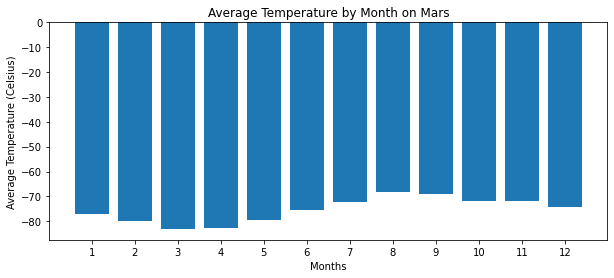

In [11]:
# months list to put into bar graph
months_list = []
for month in mars_df["month"]:
    if month not in months_list:
        months_list.append(month)

months_list.sort()

# creating groupby object to aggregate by month
mars_groupby = mars_df.groupby("month")
mean_df = mars_groupby.mean()

# Plot the bar chart
plt.figure(figsize = (10,4))
plt.bar(months_list, mean_df["min_temp"])
plt.xlabel("Months")
plt.ylabel("Average Temperature (Celsius)")
plt.title("Average Temperature by Month on Mars")
plt.xticks(months_list)
plt.show()

### The coldest month according to the bar chart is Month 4, while the warmest is Month 8.

## Which months have the lowest and the highest atmospheric pressure on Mars?

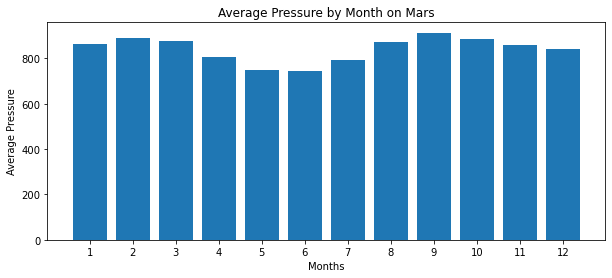

In [12]:
# Plot the bar chart
plt.figure(figsize = (10,4))
plt.bar(months_list, mean_df["pressure"])
plt.xlabel("Months")
plt.ylabel("Average Pressure")
plt.title("Average Pressure by Month on Mars")
plt.xticks(months_list)
plt.show()

### The month with the lowest average atmospheric pressure according to the bar chart is Month 6, while the highest average atmospheric is Month 9.

## About how many terrestrial (Earth) days exist in a Martian year? That is, in the time that Mars circles the Sun once, how many days elapse on Earth?

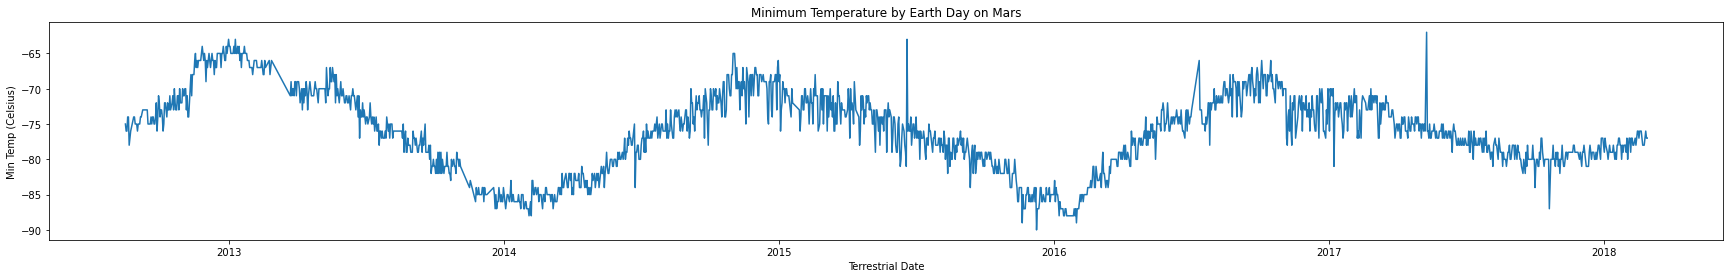

In [13]:
plt.figure(figsize=(30,4))
plt.plot(mars_df["terrestrial_date"], mars_df["min_temp"])
plt.xlabel("Terrestrial Date")
plt.ylabel("Min Temp (Celsius)")
plt.title("Minimum Temperature by Earth Day on Mars")
plt.show()

### From this graph, we can see that the minimum temperature follows an oscillating pattern every two years. This may indicate that the duration of a Martian year as measured by Earth days is approximately 1 Martian year: 2 Earth years or 1 Martian Year: 730 Earth days. A quick Google search shows that the exact ratio is 1 Martian Year: 687 Earth days, so this estimation is very close.

In [14]:
# Export Data Frame to CSV
mars_df.to_csv("Resources/mars_temp_data.csv")